Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [683]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from matplotlib import pyplot as plt
from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [684]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [685]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [686]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype=np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [687]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(841054570.6280632)


In [688]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(423493737.98284304)


In [689]:
def fitness(solution: np.ndarray) :
    # i'm trying to minimize cost
    # check if it is valid
    # when you are in valid you should never go into invalid
    return (valid(solution), -cost(solution))

def fitness2(solution: np.ndarray):
    is_valid = valid(solution)
    solution_cost = cost(solution)

    # Heavily penalize invalid solutions
    if not is_valid:
        penalty = 1e6  # A very large value to make invalid solutions uncompetitive
        return (valid(solution), -(solution_cost + penalty))  
    else:
        return (valid(solution), -solution_cost)
    
def fitness3(solution: np.ndarray):
    is_valid = valid(solution)
    solution_cost = cost(solution)

    # the penalty is proportional to the number of elements not covered, 
    # thus improving the sensitivity of the fitness function with respect to the validity of the solution.
    uncovered_elements = np.sum(np.logical_not(np.any(SETS[solution], axis=0)))
    if not is_valid:
        penalty = 1e4 * uncovered_elements  # Dynamic penalty based on uncovered elements
        return (False, -(solution_cost + penalty))
    else:
        return (True, -solution_cost)


## Improved RHMC

In [690]:
def multiple_mutationRHMC(solution: np.ndarray, strength: float=0.3) -> np.ndarray:
    # before we try to do exploitation (big steps)    
    mask=rng.random(NUM_SETS)<strength
    if not np.any(mask):
        mask[rng.integers(NUM_SETS)]=True
    new_sol=np.logical_xor(solution, mask)
    return new_sol

In [691]:
BUFFER_SIZE=50

def RHMC(initial_solution, max_steps):
    solution = initial_solution
    solution_fitness=fitness3(solution)
    history=[float(solution_fitness[1])]
    ic(fitness3(solution))

    strength=0.5
    buffer=list()
    tabu_list = []  # Tabu list for Tabu Search

    for steps in range(max_steps):
        #SELF-ADAPTIVE
        new_solution = None
        while new_solution is None or  any(np.array_equal(new_solution, t) for t in tabu_list):
            new_solution=multiple_mutationRHMC(solution, float(strength))
        
        f=fitness3(new_solution)
        history.append(float(f[1]))
        
        buffer.append(f>solution_fitness)
        buffer=buffer[-BUFFER_SIZE:]
        if sum (buffer) > 10:
            strength *= 1.1
        elif sum (buffer) < 10:
            strength /= 1.1

        # Update the solution if it improves
        if f>solution_fitness:
            solution=new_solution
            best_step=steps
            solution_fitness=fitness3(solution)
            tabu_list.append(solution)
            if len(tabu_list) > 100:
                tabu_list.pop(0)

    #ic(solution)  
    ic(fitness3(solution))
    print("Result obtained during the iteration:", best_step)


    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    _ = plt.scatter(range(len(history)), history, marker=".")
    # after some time i remove all member so set cost will be 0


## Simulated Annealing

In [692]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol=solution.copy()
    #select one bit and then change it
    i=rng.integers(0, NUM_SETS)
    new_sol[i]= not new_sol[i]
    return new_sol

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol=solution.copy()
    
    mask=rng.random( NUM_SETS)<0.01
    new_sol=np.logical_xor(solution, mask)
    return new_sol

def multiple_mutation2(solution: np.ndarray, step: int, max_steps: int) -> np.ndarray:
    new_sol = solution.copy()
    
    # Adaptive mutation rate based on progress
    mutation_rate = 0.01 + (0.05 * (step / max_steps))  # Increase mutation rate over time
    mask = rng.random(NUM_SETS) < mutation_rate
    
    new_sol = np.logical_xor(solution, mask)
    return new_sol

In [693]:
def greedy_initial_solution() -> np.ndarray:
    uncovered = np.ones(UNIVERSE_SIZE, dtype=bool)  # Start with all elements uncovered
    solution = np.zeros(NUM_SETS, dtype=bool)
    
    while np.any(uncovered):
        # Coverage ratio: number of uncovered elements per set cost
        coverage = SETS & uncovered # calculates which elements not yet covered are covered by each set. 
        # calculate the number of discovered elements covered by the set, divided by the cost of the set
        set_scores = coverage.sum(axis=1) / COSTS  # Efficiency: how many uncovered items you can cover per unit of cost 
        best_set = np.argmax(set_scores) # select the set that offers the best coverage at the lowest cost
        
        # Add the selected set to the solution
        solution[best_set] = True
        # Mark the elements covered by the selected set as covered
        uncovered &= ~SETS[best_set]
    
    return solution

In [694]:
def simulated_annealing(initial_solution, max_steps):
    solution = initial_solution
    solution_fitness = fitness3(solution)

    temperature = 10000
    best_solution = solution
    best_fitness = solution_fitness
    print("Initial fitness:", best_fitness)
    best_step=0
    best_cost=-float(solution_fitness[1])
    history = [float(solution_fitness[1])]

    # random restart
    no_improvement_steps = 0
    max_no_improvement = 500  # Max steps without improvement

    for step in range(max_steps):
        # Generate a new solution by mutation
        new_solution = multiple_mutation(solution)
        new_fitness = fitness3(new_solution)
        
        # Calculate the fitness difference
        delta_fitness = float(new_fitness[1]) - float(solution_fitness[1])
        
        # Accept the new solution if better or with a certain probability
        if delta_fitness > 0 or np.random.random() < np.exp(delta_fitness / temperature):
            solution = new_solution
            solution_fitness = new_fitness
            no_improvement_steps = 0 #reset counter
            
            # Update the best solution found
            if solution_fitness[1] > best_fitness[1]:
                best_solution = solution
                best_fitness = solution_fitness
                best_step=step
                best_cost=-float(solution_fitness[1])

        else:
            no_improvement_steps += 1

        if no_improvement_steps > max_no_improvement:
            print("Restarting from a new random solution...")
            solution = greedy_initial_solution()
            solution_fitness = fitness3(solution)
            no_improvement_steps = 0

        # Reduce the temperature
        if delta_fitness > 0:
            temperature *= 0.9  # Cool quickly if there is improvement
        else:
            temperature *= 0.99
        
        history.append(float(solution_fitness[1]))

    print("Best solution found:", best_solution)
    print("Best fitness:", best_fitness)
    print("Result obtained during the iteration:", best_step)
    print("Best cost: ", best_cost)

    plt.figure(figsize=(14, 8))
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".")
    plt.show()

ic| fitness3(solution): (True, np.float64(-252222982.64022866))
ic| fitness3(solution): (True, np.float64(-236477054.27639562))


Result obtained during the iteration: 988


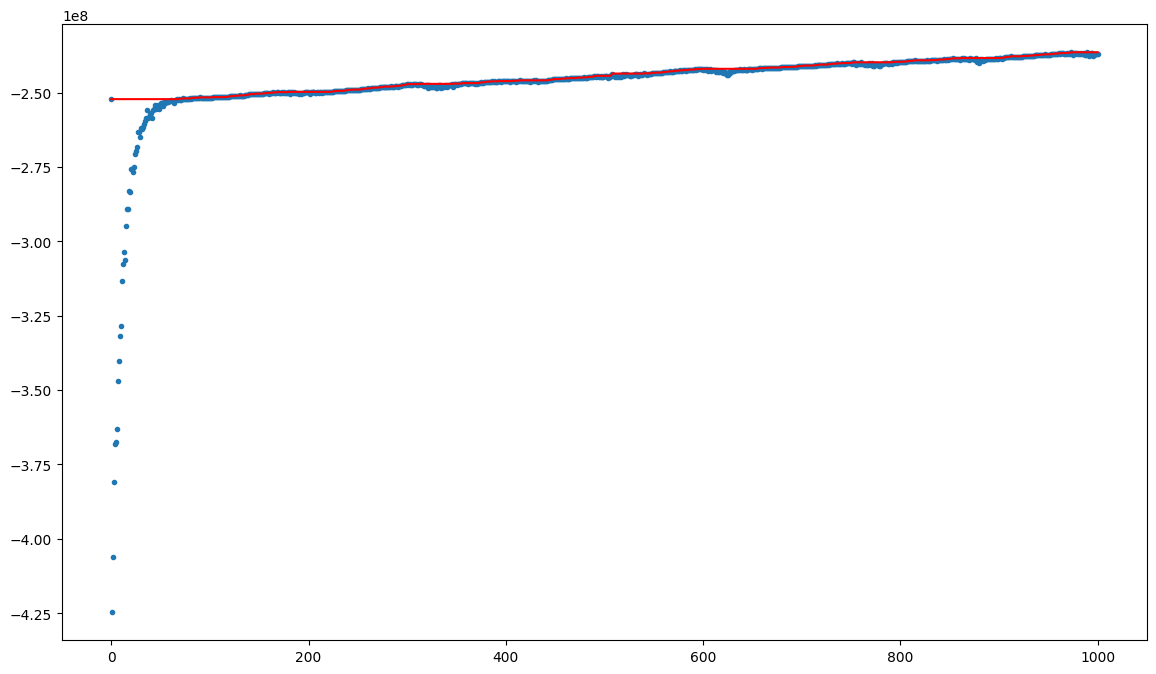

In [695]:
solution=rng.random(NUM_SETS) < .3
max_steps=1000

if (UNIVERSE_SIZE>1000):
    if(UNIVERSE_SIZE<100_000):
        max_steps=10_000
    RHMC(solution, max_steps)
else:
    simulated_annealing(solution, max_steps)